In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize 
from scipy.stats import norm
from scipy.stats import lognorm
import math
import scipy.integrate as integrate
import scipy.special as special
import os
import glob

np.set_printoptions(suppress=True)

In [2]:
# Select data location

# sample ID
reps = ['1', '2','3']


# concs
IL12 = ['0.05', '0.2', '0.5', '1']
wt_conc = '1'

# Condition folder
datapath = 'csv/D5_cont-IL12_cont-stim/'
cond = 'cont-stim_cont-IL12'

# datapath = 'csv/D5_cont-IL12_rem-stim/'
# cond = 'cont-IL12_rem-stim'

# datapath = 'csv/D5_rem-IL12_cont-stim/'
# cond = 'rem-IL12_cont-stim'

# datapath = 'csv/D5_rem-IL12_rem-stim/'
# cond = 'rem-IL12_rem-stim'



### Curve Fitting

In [3]:
# Import csv files 
df_all = pd.DataFrame()
for file_name in glob.glob(datapath+'*.csv'):
    name = file_name.split("_")
    sample = name[-5]
    rep = name[-4]
    conc = name[-3]

    
    
#     print(file_name)
#     name = file_name.split("/")[2]
#     print(name)
#     name= name.split(cond)[1]
#     print(name)
#     name = '_' + name
    x = pd.read_csv(file_name, low_memory=False)
    x.columns = [sample +'_'+ rep +'_'+ conc for col in x.columns]
#     x.columns = [str(col) + name for col in x.columns]
    df_all = pd.concat([df_all,x],axis=1)


In [4]:
df_all

,hom_3_0.2,hom_2_0.05,hom_2_0,hom_2_0.5,het_2_0,het_3_0.5,het_2_1,WT_3_1,het_2_0.2,hom_1_0.2,...,hom_3_0,hom_1_0.5,het_3_0.05,het_3_0.2,hom_2_1,het_2_0.5,het_2_0.05,hom_3_0.5,WT_1_1,hom_2_0.2
0,4173.400,4946.790,6644.48,290.028,2827.45,723.797,462.885,831.322,481.061,6205.670,...,9144.41,1282.00,624.138,6012.8200,665.980,482.127,9909.890,1450.37,509.790,483.595
1,15700.800,4500.180,11642.80,407.604,5333.90,507.543,433.953,342.434,709.181,5771.900,...,6487.99,1108.37,714.869,1360.4600,4099.940,1077.190,12925.400,4267.65,292.508,511.364
2,1440.200,2568.210,11205.00,2396.950,3554.34,2037.650,408.024,322.189,6549.370,1082.160,...,2279.44,2306.43,3290.290,372.0490,461.698,347.647,4605.300,3096.05,443.563,193.178
3,760.374,505.271,15312.90,747.874,5489.56,2085.010,974.228,425.994,494.751,2496.890,...,1328.13,2102.04,4670.110,64.5505,1246.330,783.165,3954.690,1976.91,351.651,780.875
4,4861.520,10954.300,8144.26,1069.460,4971.63,696.712,385.127,304.182,375.229,414.309,...,7608.87,2255.62,1791.410,471.5920,774.804,795.014,699.229,6553.04,557.832,878.610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function definitions

In [5]:
# double_gauss_func_2sigmas   
def double_gauss_func_2sigmas(params, x, s1_set):
    
    if s1_set == False:
        (mu1, sigma1, h1, dmu, sigma2, h2) = params
        mu2  = mu1 + dmu # define mu2 based on dmu and mu1
        result =   (h1*(1/((2*np.pi*(sigma1**2))**0.5))*np.exp(-((x-mu1)**2)/(2*(sigma1**2)))) \
        + (h2*(1/((2*np.pi*(sigma2**2))**0.5))*np.exp(-((x-mu2)**2)/(2*(sigma2**2))))
    
    else:
        (mu1, h1, dmu, sigma2, h2) = params
        mu2  = mu1 + dmu # define mu2 based on dmu and mu1
        result =   (h1*(1/((2*np.pi*(s1_set**2))**0.5))*np.exp(-((x-mu1)**2)/(2*(s1_set**2)))) \
        + (h2*(1/((2*np.pi*(sigma2**2))**0.5))*np.exp(-((x-mu2)**2)/(2*(sigma2**2))))
        
        

    return result

############################################################################################################

# residuals_double_gauss_2sigmas
# input: params, vector of length 3 containing  mu, sigma, and h for a guassian distribution; 
# input: x, vector generated using linspace spanning relevant range
# input: y_observed, actual observed y values for comparison to fit values
def residuals_double_gauss_2sigmas(params,x,y_observed, s1_set):
    if s1_set == False:
#         print('residuals_double_gauss_2sigmas, s1_set = False')
        return y_observed - double_gauss_func_2sigmas(params,x[:-1], False) # return residuals
    else:
#         print('residuals_double_gauss_2sigmas, s1_set =')
#         print(s1_set)
        return y_observed - double_gauss_func_2sigmas(params,x[:-1], s1_set) # return residuals



### Main Function 

In [6]:
def main_fun(het,hom, wt):
    # plot het and hom distributions - these should look similar to the flowjo plots

    # To make things easier, log transform my data up front and proceed with fit

    het = het[het["TCF1-YFP-A"]>0] # filter out negative values
    hom = hom[hom["TCF1-YFP-A"]>0] # filter out negative values
    wt = wt[wt["TCF1-YFP-A"]>0]

    het["TCF1-YFP_log"] = np.log10(het["TCF1-YFP-A"]) # add colunn to dataframe for logged values
    hom["TCF1-YFP_log"] = np.log10(hom["TCF1-YFP-A"]) # add colunn to dataframe for logged values
    wt["TCF1-YFP_log"] = np.log10(wt["TCF1-YFP-A"]) # add colunn to dataframe for logged values

    # use numpy.histogram
    # first element of returned histogram is y values, second is x values
    het_hist = np.histogram(het["TCF1-YFP_log"], bins = np.linspace(1,5,500)) 
    hom_hist = np.histogram(hom["TCF1-YFP_log"], bins = np.linspace(1,5,500)) 
    wt_hist = np.histogram(wt["TCF1-YFP_log"], bins = np.linspace(1,5,500))
    
    # normalize histograms so that the max y value is 1
    het_y_hist = het_hist[0] / np.array((max(het_hist[0])))
    hom_y_hist = hom_hist[0] / np.array((max(hom_hist[0])))
    wt_y_hist = wt_hist[0] / np.array((max(wt_hist[0])))
    het_hist = (het_y_hist, het_hist[1])
    hom_hist = (hom_y_hist, hom_hist[1])
    wt_hist = (wt_y_hist, wt_hist[1])

#     plt.hist(het["TCF1-YFP_log"], bins = np.linspace(1,5,500))
#     plt.hist(hom["TCF1-YFP_log"], bins = np.linspace(1,5,500))
#     plt.hist(wt["TCF1-YFP_log"], bins = np.linspace(1,5,500))
#     plt.xlim(0,5)
#     plt.xlabel("log10(YFP)")
#     plt.show()
    
    #####
    # Double Gaussian fit to het
    # Two gaussian fit to het with two separate sigmas

    x_in = np.linspace(1,5,500)

    # set bounds
    mu1_min = min(x_in) 
    sigma1_min = .27 # .27
    h1_min = 0
    dmu_min = 0.25 #.5
    sigma2_min = .2 #.27 changed to .3
    h2_min = 0


    mu1_max = 3.5
    sigma1_max = 0.4 #.4
    h1_max = np.inf
    dmu_max = 2
    sigma2_max = .4  #.4
    h2_max = np.inf


    # plot initial guess
    params0 = [3, .4, 1, 0.5, .4, 1] # initial guess for params
    y_obs = het_hist[0]

    # fit_params = scipy.optimize.least_squares(residuals, params0, x, y_obs)
    res_lsq = scipy.optimize.least_squares(residuals_double_gauss_2sigmas, params0, args=(x_in, y_obs, False), \
        bounds=([mu1_min, sigma1_min, h1_min, dmu_min, sigma2_min, h2_min], [mu1_max, sigma1_max, h1_max, dmu_max, sigma2_max, h2_max]))
    print("output of gaus fun with params - het")
    print(res_lsq.x)

    x_in = x_in[:-1]
    plt.hist(het["TCF1-YFP_log"], bins = np.linspace(1,5,500), density=True)
    plt.plot(x_in, double_gauss_func_2sigmas(res_lsq.x, x_in, False), c='r') 
    plt.title("Double guassian fit to YFP-het, two sigmas")
    plt.show()

    # Save important values
    het_double_gauss_params_2sigma = res_lsq.x
    het_double_gauss_cost_2sigma = res_lsq.cost
    het_num_params_double_2sigma = len(res_lsq.x)
    het_s1 = het_double_gauss_params_2sigma[1]
    print('het_s1')
    print(het_s1)

    # plot initial guess
    params0 = [3, 1, 0.5, .4, 1] # initial guess for params
    y_obs = hom_hist[0]
    x_in = np.linspace(1,5,500)

    # fit_params = scipy.optimize.least_squares(residuals, params0, x, y_obs)
    # for hom, set sigma1 = to het sigma1
    res_lsq = scipy.optimize.least_squares(residuals_double_gauss_2sigmas, params0, args=(x_in, y_obs, het_s1), \
        bounds=([mu1_min, h1_min, dmu_min, sigma2_min, h2_min], [mu1_max, h1_max, dmu_max, sigma2_max, h2_max]))
    print("output of gaus fun with params - hom")
    print(res_lsq.x)

    x_in = x_in[:-1]
    plt.hist(hom["TCF1-YFP_log"], bins = np.linspace(1,5,500), density=True)
    plt.plot(x_in, double_gauss_func_2sigmas(res_lsq.x, x_in, het_s1), c='r') 
    plt.title("Double guassian fit to YFP-hom, two sigmas")
    plt.show()

    # Save important values
    hom_double_gauss_params_2sigma = res_lsq.x
    hom_double_gauss_cost_2sigma = res_lsq.cost
    hom_num_params_double_2sigma = len(res_lsq.x)
    
    ####
    # Output params
    
    colnames = ['Parameter',  'het - two gaussian', 'hom - two gaussian']
    Parameter = ['mu1', 'sigma', 'h1', 'dmu', 'sigma2', 'h2']

    het_double_2sigma = het_double_gauss_params_2sigma
    het_double_2sigma = het_double_2sigma.tolist()
    hom_double_2sigma = hom_double_gauss_params_2sigma 
    hom_double_2sigma = np.insert(hom_double_2sigma, 1, het_s1) # insert sigma1 from het fit
#     hom_double_2sigma = hom_double_2sigma[0], het_s1, hom_double_2sigma[1], hom_double_2sigma[2], hom_double_2sigma[3], hom_double_2sigma[4]
    hom_double_2sigma = hom_double_2sigma.tolist()


    pd.options.display.float_format = '{:.2f}'.format

    d = {'Parameter': Parameter, 'het - two guassian': het_double_2sigma, 'hom - two gaussian': hom_double_2sigma}
    df = pd.DataFrame(d)


    display(df)
    
    #####
    # Save

    het_params = het_double_gauss_params_2sigma
    hom_params = hom_double_gauss_params_2sigma
    
    # for saving, need to add sigma1 back to hom params
    hom_params = np.insert(hom_params, 1, het_s1)
    
    np.savez(datapath + 'het'+ output_file, het_params, het_hist[1], het_hist[0])
    np.savez(datapath + 'hom'+output_file, hom_params, hom_hist[1], hom_hist[0])
    np.savez(datapath + 'wt'+output_file, wt_hist[1], wt_hist[0])
    
    
    

### Run main function on all replicates and IL12 conc

replicate: 1
IL12 conc: 0.05
        WT_1_1
0      509.790
1      292.508
2      443.563
3      351.651
4      557.832
...        ...
34325  607.283
34326  321.524
34327  740.015
34328  328.753
34329  366.694

[34330 rows x 1 columns]
output of gaus fun with params - het
[3.0272922  0.32637709 0.4036809  0.63123812 0.24393282 0.48431116]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

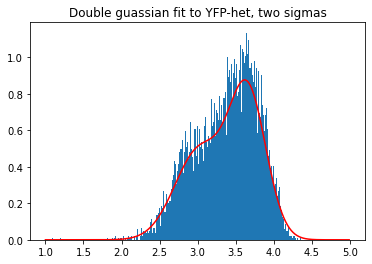

het_s1
0.3263770941494043
output of gaus fun with params - hom
[3.25722949 0.32812115 0.64620525 0.26753774 0.55511696]


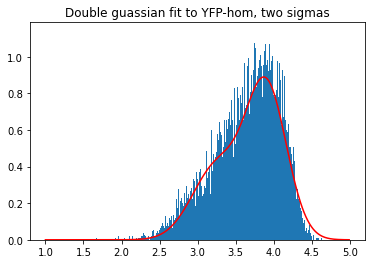

,Parameter,het - two guassian,hom - two gaussian
0,mu1,3.03,3.26
1,sigma,0.33,0.33
2,h1,0.40,0.33
3,dmu,0.63,0.65
4,sigma2,0.24,0.27
5,h2,0.48,0.56


replicate: 1
IL12 conc: 0.2
       WT_1_1
0      509.79
1      292.51
2      443.56
3      351.65
4      557.83
...       ...
34325  607.28
34326  321.52
34327  740.01
34328  328.75
34329  366.69

[34330 rows x 1 columns]
output of gaus fun with params - het
[2.84431821 0.27       0.52398918 0.6486777  0.2        0.10674903]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

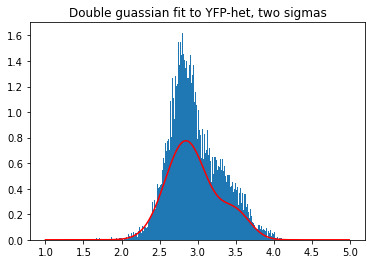

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.84683742 0.51741451 0.7337058  0.28113796 0.36654344]


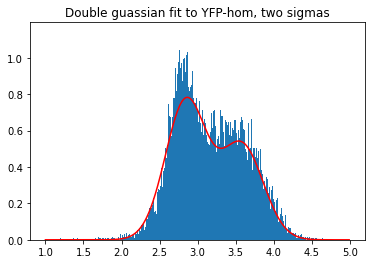

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.84,2.85
1,sigma,0.27,0.27
2,h1,0.52,0.52
3,dmu,0.65,0.73
4,sigma2,0.20,0.28
5,h2,0.11,0.37


replicate: 1
IL12 conc: 0.5
       WT_1_1
0      509.79
1      292.51
2      443.56
3      351.65
4      557.83
...       ...
34325  607.28
34326  321.52
34327  740.01
34328  328.75
34329  366.69

[34330 rows x 1 columns]
output of gaus fun with params - het
[2.79762289 0.27       0.55355997 0.6591536  0.2        0.09335745]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

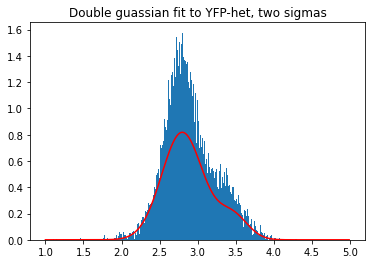

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.79548376 0.52476795 0.71677477 0.25933323 0.23048017]


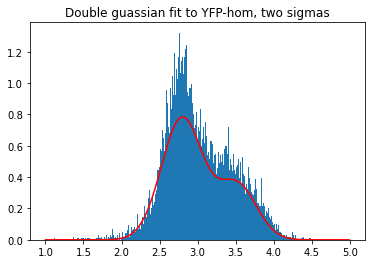

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.80,2.80
1,sigma,0.27,0.27
2,h1,0.55,0.52
3,dmu,0.66,0.72
4,sigma2,0.20,0.26
5,h2,0.09,0.23


replicate: 1
IL12 conc: 1
       WT_1_1
0      509.79
1      292.51
2      443.56
3      351.65
4      557.83
...       ...
34325  607.28
34326  321.52
34327  740.01
34328  328.75
34329  366.69

[34330 rows x 1 columns]
output of gaus fun with params - het
[2.7466681  0.27       0.51143747 0.70808694 0.2        0.05817786]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

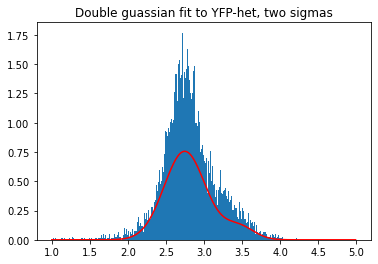

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.78344641 0.51599031 0.73188377 0.2649254  0.17041841]


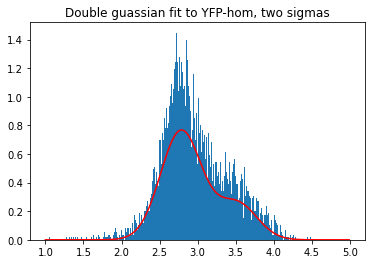

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.75,2.78
1,sigma,0.27,0.27
2,h1,0.51,0.52
3,dmu,0.71,0.73
4,sigma2,0.20,0.26
5,h2,0.06,0.17


replicate: 2
IL12 conc: 0.05
       WT_2_1
0      800.08
1      627.65
2      465.67
3      683.54
4      376.62
...       ...
24248  341.55
24249  420.71
24250  587.92
24251  342.41
24252  712.83

[24253 rows x 1 columns]
output of gaus fun with params - het
[3.01499406 0.30278378 0.36559224 0.62721408 0.23867642 0.49350517]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

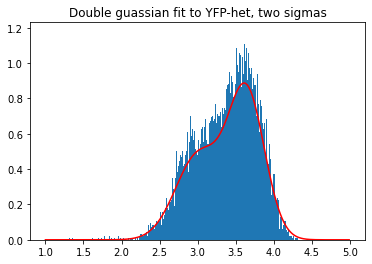

het_s1
0.3027837766958885
output of gaus fun with params - hom
[3.20713286 0.31706359 0.65606482 0.27069141 0.57788465]


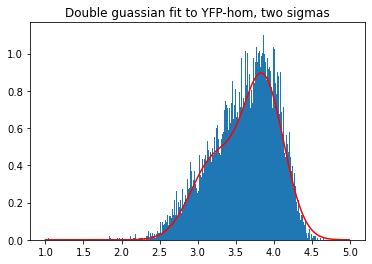

,Parameter,het - two guassian,hom - two gaussian
0,mu1,3.01,3.21
1,sigma,0.30,0.30
2,h1,0.37,0.32
3,dmu,0.63,0.66
4,sigma2,0.24,0.27
5,h2,0.49,0.58


replicate: 2
IL12 conc: 0.2
       WT_2_1
0      800.08
1      627.65
2      465.67
3      683.54
4      376.62
...       ...
24248  341.55
24249  420.71
24250  587.92
24251  342.41
24252  712.83

[24253 rows x 1 columns]
output of gaus fun with params - het
[2.85479784 0.27       0.5082511  0.65762369 0.2        0.0816725 ]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

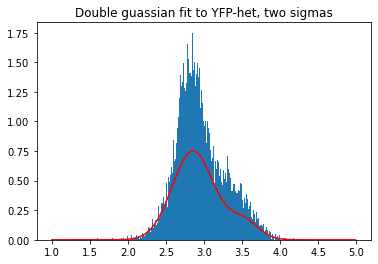

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.83462238 0.5449452  0.69995192 0.26302512 0.28970121]


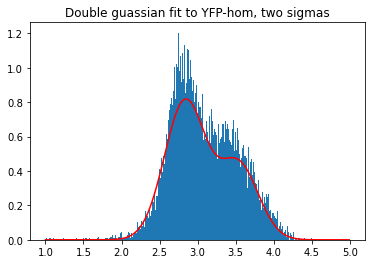

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.85,2.83
1,sigma,0.27,0.27
2,h1,0.51,0.54
3,dmu,0.66,0.70
4,sigma2,0.20,0.26
5,h2,0.08,0.29


replicate: 2
IL12 conc: 0.5
       WT_2_1
0      800.08
1      627.65
2      465.67
3      683.54
4      376.62
...       ...
24248  341.55
24249  420.71
24250  587.92
24251  342.41
24252  712.83

[24253 rows x 1 columns]
output of gaus fun with params - het
[2.83200695 0.27       0.52846399 0.66368749 0.2        0.06600733]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

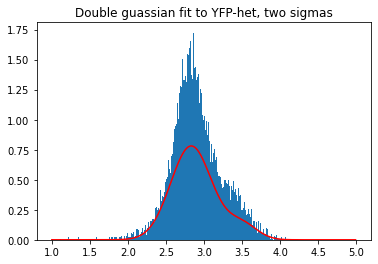

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.80305402 0.55775059 0.68596141 0.24229635 0.23796065]


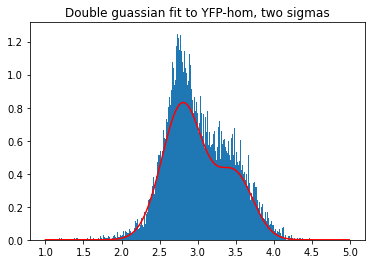

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.83,2.80
1,sigma,0.27,0.27
2,h1,0.53,0.56
3,dmu,0.66,0.69
4,sigma2,0.20,0.24
5,h2,0.07,0.24


replicate: 2
IL12 conc: 1
       WT_2_1
0      800.08
1      627.65
2      465.67
3      683.54
4      376.62
...       ...
24248  341.55
24249  420.71
24250  587.92
24251  342.41
24252  712.83

[24253 rows x 1 columns]
output of gaus fun with params - het
[2.81132076 0.27       0.46757686 0.69317203 0.2        0.03985382]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

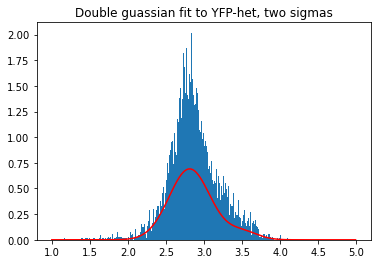

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.77998457 0.55192773 0.72115044 0.2544892  0.19812981]


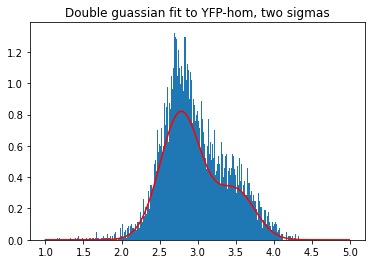

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.81,2.78
1,sigma,0.27,0.27
2,h1,0.47,0.55
3,dmu,0.69,0.72
4,sigma2,0.20,0.25
5,h2,0.04,0.20


replicate: 3
IL12 conc: 0.05
       WT_3_1
0      831.32
1      342.43
2      322.19
3      425.99
4      304.18
...       ...
28828 1010.73
28829  667.36
28830  396.94
28831  339.50
28832  515.72

[28833 rows x 1 columns]
output of gaus fun with params - het
[2.98022344 0.29532352 0.36148112 0.64143796 0.27463501 0.53740746]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


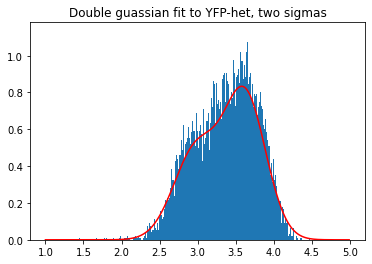

het_s1
0.2953235214040847
output of gaus fun with params - hom
[3.09128401 0.26185329 0.74361791 0.33083629 0.70256408]


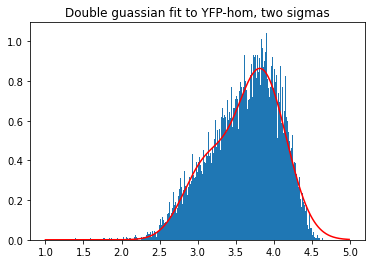

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.98,3.09
1,sigma,0.30,0.30
2,h1,0.36,0.26
3,dmu,0.64,0.74
4,sigma2,0.27,0.33
5,h2,0.54,0.70


replicate: 3
IL12 conc: 0.2
       WT_3_1
0      831.32
1      342.43
2      322.19
3      425.99
4      304.18
...       ...
28828 1010.73
28829  667.36
28830  396.94
28831  339.50
28832  515.72

[28833 rows x 1 columns]
output of gaus fun with params - het
[2.90107728 0.27       0.55365223 0.62689924 0.2        0.10066974]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

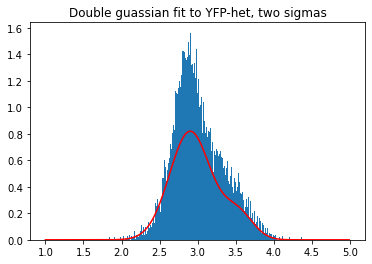

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.82759345 0.53190832 0.73557957 0.31657161 0.56285779]


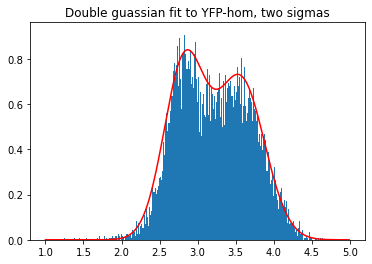

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.90,2.83
1,sigma,0.27,0.27
2,h1,0.55,0.53
3,dmu,0.63,0.74
4,sigma2,0.20,0.32
5,h2,0.10,0.56


replicate: 3
IL12 conc: 0.5
       WT_3_1
0      831.32
1      342.43
2      322.19
3      425.99
4      304.18
...       ...
28828 1010.73
28829  667.36
28830  396.94
28831  339.50
28832  515.72

[28833 rows x 1 columns]
output of gaus fun with params - het
[2.84072039 0.27       0.5113187  0.67426019 0.2        0.05406919]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

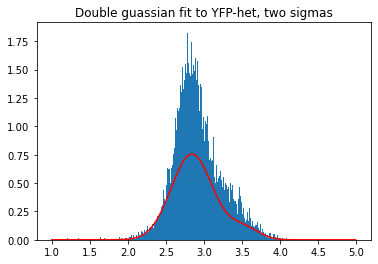

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.80212287 0.54222119 0.71691371 0.30006981 0.38827817]


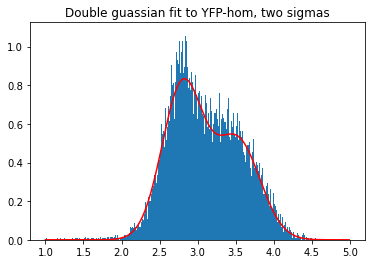

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.84,2.80
1,sigma,0.27,0.27
2,h1,0.51,0.54
3,dmu,0.67,0.72
4,sigma2,0.20,0.30
5,h2,0.05,0.39


replicate: 3
IL12 conc: 1
       WT_3_1
0      831.32
1      342.43
2      322.19
3      425.99
4      304.18
...       ...
28828 1010.73
28829  667.36
28830  396.94
28831  339.50
28832  515.72

[28833 rows x 1 columns]
output of gaus fun with params - het
[2.7795756  0.27       0.48277034 0.67977099 0.2        0.05541969]


/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kathleenabadie/anaconda2/envs/env01/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarnin

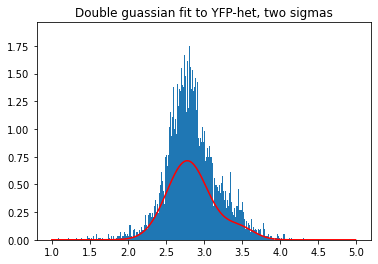

het_s1
0.2700000000000001
output of gaus fun with params - hom
[2.78112657 0.49408138 0.73569868 0.31090132 0.26203603]


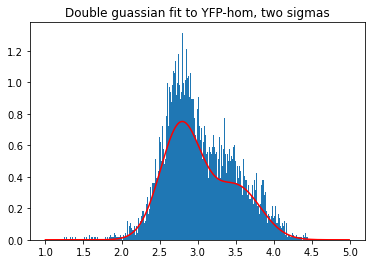

,Parameter,het - two guassian,hom - two gaussian
0,mu1,2.78,2.78
1,sigma,0.27,0.27
2,h1,0.48,0.49
3,dmu,0.68,0.74
4,sigma2,0.20,0.31
5,h2,0.06,0.26


In [7]:
for rep in reps:
    for c in IL12:
        print('replicate:', rep)
        print('IL12 conc:', c)
        het = df_all[['het' +'_'+ rep +'_'+ c]].dropna()
        het.rename(columns = {list(het)[0]: 'TCF1-YFP-A'}, inplace = True)
        hom = df_all[['hom' +'_'+ rep +'_'+ c]].dropna()
        hom.rename(columns = {list(hom)[0]: 'TCF1-YFP-A'}, inplace = True)
        wt = df_all[['WT' +'_'+ rep +'_'+ wt_conc]].dropna()
        print(wt)
        wt.rename(columns = {list(wt)[0]: 'TCF1-YFP-A'}, inplace = True)
        output_file = rep + '_' + c + 'ng.npz'
        main_fun(het, hom, wt)


In [8]:
df_all

,hom_3_0.2,hom_2_0.05,hom_2_0,hom_2_0.5,het_2_0,het_3_0.5,het_2_1,WT_3_1,het_2_0.2,hom_1_0.2,...,hom_3_0,hom_1_0.5,het_3_0.05,het_3_0.2,hom_2_1,het_2_0.5,het_2_0.05,hom_3_0.5,WT_1_1,hom_2_0.2
0,4173.40,4946.79,6644.48,290.03,2827.45,723.80,462.88,831.32,481.06,6205.67,...,9144.41,1282.00,624.14,6012.82,665.98,482.13,9909.89,1450.37,509.79,483.60
1,15700.80,4500.18,11642.80,407.60,5333.90,507.54,433.95,342.43,709.18,5771.90,...,6487.99,1108.37,714.87,1360.46,4099.94,1077.19,12925.40,4267.65,292.51,511.36
2,1440.20,2568.21,11205.00,2396.95,3554.34,2037.65,408.02,322.19,6549.37,1082.16,...,2279.44,2306.43,3290.29,372.05,461.70,347.65,4605.30,3096.05,443.56,193.18
3,760.37,505.27,15312.90,747.87,5489.56,2085.01,974.23,425.99,494.75,2496.89,...,1328.13,2102.04,4670.11,64.55,1246.33,783.16,3954.69,1976.91,351.65,780.88
4,4861.52,10954.30,8144.26,1069.46,4971.63,696.71,385.13,304.18,375.23,414.31,...,7608.87,2255.62,1791.41,471.59,774.80,795.01,699.23,6553.04,557.83,878.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37515,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
37516,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
37517,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
37518,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
